In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import astropy.io.fits as fits
import photutils as ph
import pandas as pd
import glob

bias = 0 shutter time(just electronics)

dark = bias + dar current (Non zero with shudder on)

In [2]:
def master_bias_remover(bias):
    summator = bias[0]-bias[0]
    for _,itm in enumerate(bias):
        summator += itm
    summator = summator/len(bias)
    return summator

def getImageFile(location):
    """
    Gets the 2D array from the given fits file
    """
    return fits.open(location)[0].data

def subtraction(list1, list2):
    """
    Subraction with numpy arrays wraps around. So if the value were to be
    negative it would instead become the max number and continue the
    subtraction. So if 10 was the max then 6-7=9 not 6-7=1
    """
    
    #What we will be outputing at the end
    output = list()
    
    #First for loop. Gives current y location and all the x-values
    #  along that y-location
    for y,xvalues in enumerate(list1):
        
        # Creating list for x values after subtraction at the current y
        xterms = list()
        
        # gives the current x value location and the value at that location
        #  Because of how this is written we are only getting the
        #  value at that x,y location from list1
        for x,value1 in enumerate(xvalues):
            # list2 value at that x,y location
            value2 = list2[y][x]
            
            #Finally the math
            if value1 > value2:
                # If the value for the first list is larger than the second
                #  one we can do a standard subtraction
                value = value1 - value2
            elif value1 < value2:
                # If the second number is larger then I'll reverse the order
                #  This is an absolute value version of the math
                value = value2 - value1
            else:
                #the last instance is if they are equal
                value = 0
            
            # adds value from above to the value for the current x
            xterms.append(value)
        # Adds all the values for the given x to the current y
        output.append(xterms)
    
    return np.array(output)
    


def gain(meanFlat1,meanFlat2, meanBias1,meanBias2, sdFlat,sdBias):
    num = (meanFlat1+meanFlat2) - (meanBias1+meanBias2)
    denom = sdFlat**2 - sdBias**2
    return num/denom

In [3]:
!ls  data_wolf/

bias.0006.fits       flat.0012.fits       flat.0030.fits
bias.0007.fits       flat.0013.fits       flat.0031.fits
bias.0008.fits       flat.0014.fits       flat.0032.fits
bias.0009.fits       flat.0015.fits       flat.0033.fits
bias.0010.fits       flat.0016.fits       flat.0034.fits
bias.0011.fits       flat.0017.fits       flat.0035.fits
bias.0012.fits       flat.0018.fits       flat.0036.fits
bias.0013.fits       flat.0019.fits       flat.0037.fits
bias.0014.fits       flat.0020.fits       flat.0038.fits
bias.0015.fits       flat.0021.fits       flat.0039.fits
bias.0016.fits       flat.0022.fits       flat.0040.fits
flat.0005.fits       flat.0023.fits       flat.0041.fits
flat.0006.fits       flat.0024.fits       wolf1346_.0001.fits
flat.0007.fits       flat.0025.fits       wolf1346_.0002.fits
flat.0008.fits       flat.0026.fits       wolf1346_.0003.fits
flat.0009.fits       flat.0027.fits       wolf1346_m.0001.fits
flat.0010.fits       flat.0028.fits
flat.0011.fits       flat.0029.

In [4]:
bias_locations = ["bias.0006.fits", "bias.0007.fits", "bias.0008.fits", 
                 "bias.0009.fits", "bias.0010.fits", "bias.0011.fits", 
                 "bias.0012.fits", "bias.0013.fits", "bias.0014.fits", 
                 "bias.0015.fits", "bias.0016.fits"]

In [5]:
bias_frames = list()
for _,name in enumerate(bias_locations):
    file = fits.open("data_wolf/" + name)
    bias_frames.append(file[0].data)

In [6]:
master_bias = master_bias_remover(bias_frames)

In [7]:
image = getImageFile("data_wolf/wolf1346_.0001.fits")

Overscan: Region at the edge of an image. In our case it appears to be two pixels on each side

In [8]:
image_noBias = image - master_bias

In [9]:
for _,itm in enumerate(bias_frames):
    print(itm.mean())
print("\n\n" + str(master_bias.mean()))

351.70354319927594
351.3568139518693
351.65315007774245
351.7383458262746
351.675116381611
351.7116537095913
351.40129446984287
351.67762200923625
351.6943257292706
351.5752312547864
351.4999043883874


351.47656093552536


In [10]:
image.min()

289

In [11]:
image_noBias.min()

-5347.818181818182

In [12]:
#Finding overscan lines
rows = list()
for i,itm in enumerate(image):
    if np.median(itm) > 500:
        rows.append(i)
    
rows = np.array(rows)

columns = list()
for i,itm in enumerate(image.transpose()):
    if np.median(itm) > 500:
        columns.append(i)
columns = np.array(columns)

In [13]:
#Removing overscan lines
image_noRows = image_noBias[rows]
trImage = image_noRows.transpose()
image_noOverscan1 = trImage[columns]
image_noOverscan_noBias = image_noOverscan1.transpose()


In [14]:
flats_locations = glob.glob("data_wolf/flat.*.fits")

SDSS

In [15]:
flats_files = list()
for _,name in enumerate(flats_locations):
    file = fits.open(name)
    flats_files.append(file[0].data)
flats_files = np.array(flats_files)

In [16]:
flats_files_header = list()
for _,name in enumerate(flats_locations):
    file = fits.open(name)
    flats_files_header.append(file[0].header)

In [17]:
jc_ones = list()
wash_ones = list()
for i,name in enumerate(flats_files_header):
    print(name["FILTER"], name["FILENAME"])
    if name["FILTER"] == 'J-C Rc':
        jc_ones.append(i)
    else:
        wash_ones.append(i)


J-C Rc flat.0031.fits
J-C Rc flat.0027.fits
Wash M flat.0007.fits
Wash M flat.0011.fits
Wash M flat.0010.fits
Wash M flat.0006.fits
J-C Rc flat.0026.fits
J-C Rc flat.0030.fits
J-C Rc flat.0040.fits
J-C Rc flat.0017.fits
J-C Rc flat.0037.fits
J-C Rc flat.0021.fits
J-C Rc flat.0020.fits
J-C Rc flat.0036.fits
Wash M flat.0016.fits
J-C Rc flat.0041.fits
J-C Rc flat.0039.fits
Wash M flat.0015.fits
J-C Rc flat.0023.fits
J-C Rc flat.0035.fits
J-C Rc flat.0019.fits
J-C Rc flat.0018.fits
J-C Rc flat.0034.fits
J-C Rc flat.0022.fits
Wash M flat.0014.fits
J-C Rc flat.0038.fits
J-C Rc flat.0025.fits
J-C Rc flat.0033.fits
Wash M flat.0009.fits
J-C Rc flat.0029.fits
Wash M flat.0013.fits
Wash M flat.0005.fits
Wash M flat.0012.fits
J-C Rc flat.0028.fits
Wash M flat.0008.fits
J-C Rc flat.0032.fits
J-C Rc flat.0024.fits


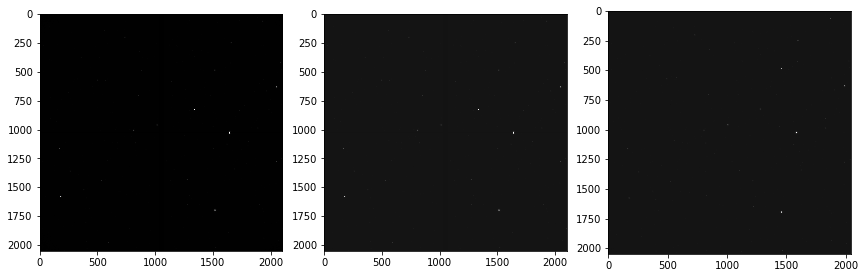

In [18]:
fig, ax = plt.subplots(1,3)

fig.set_size_inches(12,6)

fig.tight_layout()

#Beginning
ax[0].imshow(image,cmap=plt.cm.gray)

#After Bias
ax[1].imshow(image_noBias,cmap=plt.cm.gray)
#No Bias no overscan
ax[2].imshow(image_noOverscan_noBias,cmap=plt.cm.gray)

In [19]:
image_noOverscan_noBias

array([[-1062.45454545, -1039.45454545,  -999.18181818, ...,
         -507.        ,  -545.        ,  -544.27272727],
       [  161.54545455,   164.54545455,   159.09090909, ...,
          179.27272727,   169.45454545,   176.        ],
       [  172.        ,   161.09090909,   150.45454545, ...,
          153.36363636,   172.        ,   169.45454545],
       ...,
       [  158.36363636,   149.63636364,   157.36363636, ...,
          174.90909091,   164.09090909,   168.        ],
       [  160.18181818,   163.18181818,   178.90909091, ...,
          195.09090909,   154.45454545,   168.90909091],
       [ -813.63636364,  -807.72727273,  -756.18181818, ...,
        -1074.09090909, -1083.18181818, -1097.36363636]])

In [20]:
fixed_image = getImageFile("quadRU.fits")

In [21]:
temp = ph.DAOStarFinder(threshold=0.5*np.median(fixed_image), fwhm=3,sharplo=0.35)
objects = temp.find_stars(fixed_image)
objects

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,563.323057603488,2.53623422757892,0.38136096560476934,0.9528118622658923,0.27479632984109664,25,0.0,60898.975660230615,232.51808317023546,-5.916141835168763
2,565.1658558180326,5.3354296937597345,0.5251776794445369,-0.09417415676426125,0.3116921350400274,25,0.0,60956.34586339729,312.3917412359155,-6.236748859563409
3,172.86072620903678,24.84289806759428,0.398716873942232,0.3890645257030233,-0.15485103891582017,25,0.0,3875.4178607834847,13.961660560948811,-2.862342687832489
4,587.5847271152236,36.755588364098806,0.4516680009779857,0.3364861997236897,-0.22171365359731304,25,0.0,2162.562941680303,6.548422811294736,-2.0403417817230136
5,550.5956561538496,40.52303259994759,0.45037789793670857,0.3312386645044196,-0.10212560532276478,25,0.0,757.528377357474,1.8650398554964813,-0.6767202925564698
6,10.546901955011585,53.16353087784757,0.473073813356435,0.41097969531704737,0.13129919801415071,25,0.0,591.2629764164338,1.3901899712197598,-0.35768537800053396
7,306.8259467297199,53.97188775660031,0.4450968705936288,0.2387464862318359,-0.20232565550289225,25,0.0,638.0527134510223,1.3577778796793336,-0.3320718226527922
8,288.2560028419897,58.43175778583187,0.49137038934857796,0.0949540222718624,-0.07838321643673586,25,0.0,683.9316838731509,1.586419813284917,-0.5010453131711502
9,963.6276121554017,60.62026901614525,0.43854673523456794,0.44704590875803474,-0.24134038947773223,25,0.0,681.3561322929083,1.3921271860787072,-0.3591972866218178


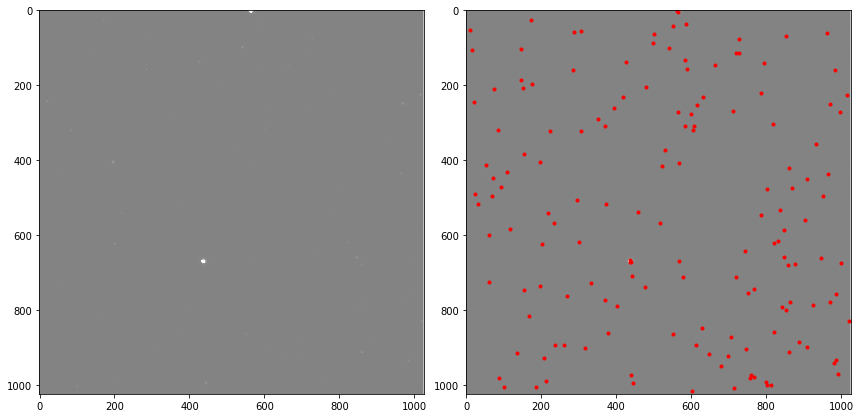

In [22]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

# Image given by class
ax[0].imshow(fixed_image, cmap=plt.cm.gray)

ax[1].imshow(fixed_image,cmap=plt.cm.gray)

# Objects
ax[1].plot(objects["xcentroid"],objects["ycentroid"],color="red",marker="o",linestyle="None",markersize=3);


In [23]:
fixed_image

array([[ 1.01618520e+04,  2.61122895e+02,  2.45189498e+02, ...,
         3.04910327e+02,  2.94579317e+04,  2.93616404e+04],
       [ 1.03162668e+04,  2.64561610e+02,  2.61962700e+02, ...,
         2.90272307e+02,  2.93651906e+04,  2.91827213e+04],
       [ 1.02007101e+04,  2.62341308e+02,  2.69187986e+02, ...,
         2.96814186e+02,  2.90899314e+04,  2.91827213e+04],
       ...,
       [ 9.47799678e+03,  2.33501954e+02,  2.30738582e+02, ...,
         4.40080105e+02,  2.56387692e+04,  2.57785397e+04],
       [ 9.74629869e+03,  2.59858801e+02,  2.51449294e+02, ...,
         4.34211750e+02,  2.55006280e+04,  2.59367700e+04],
       [ 8.40775996e+03, -3.89932355e+01, -2.76036183e+01, ...,
        -1.03570948e+03,  2.08008294e+03,  2.09440023e+03]])

In [30]:
# https://photutils.readthedocs.io/en/stable/api/photutils.CircularAperture.html#photutils.CircularAperture
r=2
circ_ap = ph.CircularAperture([objects["xcentroid"],objects["ycentroid"]], r)
phot_table = ph.aperture_photometry(fixed_image, circ_ap)
print(phot_table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1   563.323057603488   2.53623422757892    769289.32980159
  2  565.1658558180326 5.3354296937597345  607893.7121771859
  3 172.86072620903678  24.84289806759428 37637.831803469104
  4  587.5847271152236 36.755588364098806  21619.06031301055
  5  550.5956561538496  40.52303259994759  8096.042848591713
  6 10.546901955011585  53.16353087784757  6421.738352893766
  7  306.8259467297199  53.97188775660031  6777.723144188688
  8  288.2560028419897  58.43175778583187  7196.065447754016
  9  963.6276121554017  60.62026901614525  7662.954923047189
 10  501.4397205202975  62.76389889004376  7621.335717873588
...                ...                ...                ...
143  758.4105321782171  981.6532522642909  19095.74591956446
144 212.10184292005087  987.8142464830703   8771.09178050686
145  800.3053258289724  

https://photutils.readthedocs.io/en/stable/index.html

https://photutils.readthedocs.io/en/stable/aperture.html


 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1   563.323057603488   2.53623422757892    769289.32980159
  2  565.1658558180326 5.3354296937597345  607893.7121771859
  3 172.86072620903678  24.84289806759428 37637.831803469104
  4  587.5847271152236 36.755588364098806  21619.06031301055
  5  550.5956561538496  40.52303259994759  8096.042848591713
  6 10.546901955011585  53.16353087784757  6421.738352893766
  7  306.8259467297199  53.97188775660031  6777.723144188688
  8  288.2560028419897  58.43175778583187  7196.065447754016
  9  963.6276121554017  60.62026901614525  7662.954923047189
 10  501.4397205202975  62.76389889004376  7621.335717873588
...                ...                ...                ...
143  758.4105321782171  981.6532522642909  19095.74591956446
144 212.10184292005087  987.8142464830703   8771.09178050686
145  800.3053258289724  